In [7]:
import numpy as np
import pandas as pd

In [8]:
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

In [23]:
import os

Fs = 500
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

train_features = np.zeros([0,8])
train_labels = np.zeros([0])
test_features = np.zeros([0,8])
test_labels = np.zeros([0])
for shift in range(0,1): 
    for files in sorted(os.listdir(f'Subject_7/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        if int(class_) in [1,2,3]:
            df = pd.read_csv(f'Subject_7/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            if not class_.startswith('9'):
                rms_feature = feaData.sum(0)
                baseline = 2*rms_feature[-50:].mean()
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            if rep_.startswith('2'):
                test_features = np.concatenate([test_features,feaData])
                test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                train_features = np.concatenate([train_features,feaData])
                train_labels = np.concatenate([train_labels,np.ones_like(feaData)[:,0]*int(class_)-1])

print(train_features)
print(train_labels) 

[[0.00595526 0.06338212 0.02948504 ... 0.01262681 0.01025379 0.00546039]
 [0.00633821 0.05708241 0.03001254 ... 0.01485386 0.01022313 0.00497938]
 [0.00692959 0.06068548 0.02929817 ... 0.0176715  0.01204156 0.00608559]
 ...
 [0.01022313 0.00598156 0.00641206 ... 0.0418484  0.12512578 0.0170109 ]
 [0.00947425 0.00563018 0.00563018 ... 0.04353558 0.11172364 0.01456583]
 [0.005795   0.00177158 0.00367364 ... 0.01014609 0.01555568 0.00407849]]
[0. 0. 0. ... 1. 1. 2.]


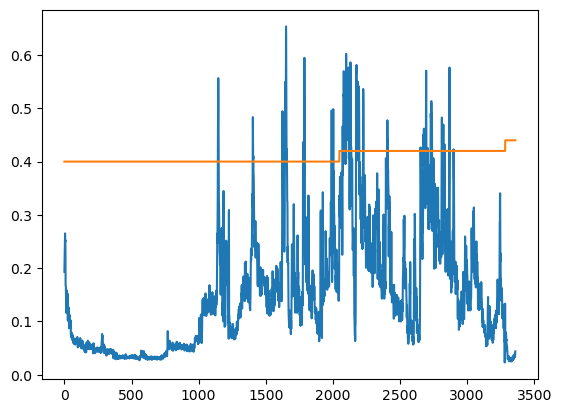

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_features.sum(1))
plt.plot(train_labels/50+ 0.4)

In [17]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', C=100).fit(train_features, train_labels)
reg.score(train_features, train_labels)#, reg.score(test_features, test_labels)

0.9853345554537122

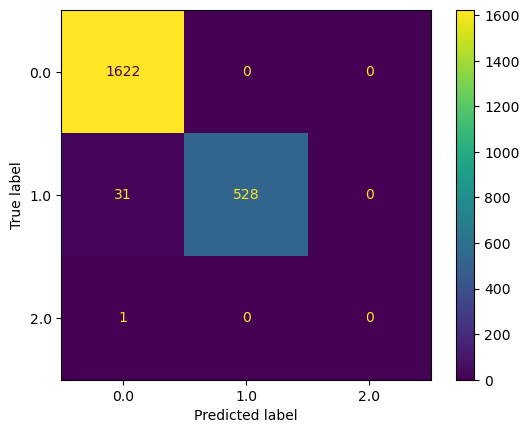

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(train_labels, reg.predict(train_features)),
                            display_labels=reg.classes_)
disp.plot()

In [19]:
from joblib import dump, load
dump(reg, 'LogisticRegression1.joblib') 

['LogisticRegression1.joblib']

In [21]:
accuracy_grid = np.zeros([3,3])
accuracy_list = []
for shift in range(0,1):
    test_features = np.zeros([0,8])
    test_labels = np.zeros([0])
    for files in sorted(os.listdir(f'Subject_7/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        df = pd.read_csv(f'Subject_7/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
        data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
        data_arr -= 121
        data_arr /= 255.0
        feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
        
        if not class_.startswith('9'):
            rms_feature = feaData.sum(0)
            baseline = 2*rms_feature[-50:].mean()
            start_ = np.argmax(rms_feature[::1]>baseline)
            end_  = -np.argmax(rms_feature[::-1]>baseline)
            feaData = feaData.T[start_:end_]
        else:
            feaData = feaData.T
        
        test_features = np.concatenate([test_features,feaData])
        test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
    accuracy_list += [reg.score(test_features,test_labels)]


In [22]:
accuracy_list

[0.955654761904762]